<a href="https://colab.research.google.com/github/niklasdonth/niklasdonth/blob/main/R_double_ml_multiway_cluster_gesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# R: Cluster Robust Double Machine Learning


## Motivation

In many empirical applications, errors exhibit a clustered structure such that the usual i.i.d. assumption does not hold anymore. In order to perform valid statistical inference, researchers have to account for clustering. In this notebook, we will shortly emphasize the consequences of clustered data on inference based on the double machine learning (DML) approach as has been considered in [Chiang et al. (2021)](https://doi.org/10.1080/07350015.2021.1895815). We will demonstrate how users of the [DoubleML](https://docs.doubleml.org/stable/index.html) package can account for one- and two-way clustering in their analysis.

Clustered errors in terms of one or multiple dimensions might arise in many empirical applications. For example, in a cross-sectional study, errors might be correlated (i) within regions (one-way clustering) or (ii) within regions and industries at the same time (two-way clustering). Another example for two-way clustering, discussed in [Chiang et al. (2021)](https://doi.org/10.1080/07350015.2021.1895815), refers to market share data with market shares being subject to shocks on the market and product level at the same time. We refer to [Cameron et al. (2011)](https://doi.org/10.1198/jbes.2010.07136) for an introduction to multiway clustering and a illustrative list of empirical examples.

## Clustering and double machine learning

Clustering creates a challenge to the double machine learning (DML) approach in terms of

1. a necessary adjustment of the formulae used for estimation of the variance covariance matrix, standard errors, p-values etc., and,
2. an adjusted resampling scheme for the cross-fitting algorithm.

The first point equally applies to classical statistical models, for example a linear regression model (see, for example [Cameron et al. 2011](https://doi.org/10.1198/jbes.2010.07136)). The second point arises because the clustering implies a correlation of errors from train and test samples if the standard cross-fitting procedure suggested in [Chernozhukov et al. (2018)](https://doi.org/10.1111/ectj.12097) was employed. The DML approach builds on independent sample splits into partitions that are used for training of the machine learning (ML) model learners and generation of predictions that are eventually used for solving the score function. For a motivation of the necessity of sample splitting, we refer to the illustration example in the [user guide](
https://docs.doubleml.org/stable/guide/basics.html#sample-splitting-to-remove-bias-induced-by-overfitting) as well as to the explanation in [Chernozhukov et al. (2018)](https://doi.org/10.1111/ectj.12097) .

In order to achieve independent data splits in a setting with one-way or multi-way clustering, [Chiang et al. (2021)](https://doi.org/10.1080/07350015.2021.1895815) develop an updated  $K$-fold sample splitting procedure that ensures independent sample splits: The data set is split into disjoint partitions in terms of all clustering dimensions. For example, in a situation with two-way clustering, the data is split into $K^2$ folds. The machine learning models are then trained on a specific fold and used for generation of predictions in hold-out samples. Thereby, the sample splitting procedure ensures that the hold-out samples do not contain observations of the same clusters as used for training.

In [ ]:
install.packages(c("hdm", "mlr3", "mlr3learners","ggplot2",'DoubleML','gridExtra','reshape2'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppEigen’, ‘bbotk’, ‘glmnet’, ‘future.apply’, ‘mlr3misc’, ‘paradox’, ‘mlr3tuning’, ‘readstata13’, ‘plyr’




In [ ]:
library('hdm')
library('DoubleML')
library('mlr3')
library('mlr3learners')
# surpress messages from mlr3 package during fitting
lgr::get_logger("mlr3")$set_threshold("warn")

library('ggplot2')
library('reshape2')
library('gridExtra')

## A Motivating Example: Two-Way Cluster Robust DML

In a first part, we show how the two-way cluster robust double machine learning (DML) ([Chiang et al. 2021](https://doi.org/10.1080/07350015.2021.1895815)) can be implemented with the [DoubleML](https://docs.doubleml.org/stable/index.html) package.
[Chiang et al. (2021)](https://doi.org/10.1080/07350015.2021.1895815) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

### Simulate two-way cluster data

We use the PLIV data generating process described in Section 4.1 of [Chiang et al. (2021)](https://doi.org/10.1080/07350015.2021.1895815).
The DGP is defined as
$$\begin{aligned}
Z_{ij} &= X_{ij}' \xi_0 + V_{ij}, \\
D_{ij} &= Z_{ij}' \pi_{10} + X_{ij}' \pi_{20} + v_{ij}, \\
Y_{ij} &= D_{ij} \theta + X_{ij}' \zeta_0 + \varepsilon_{ij},
\end{aligned}$$
with
$$\begin{aligned}
X_{ij} &= (1 - \omega_1^X - \omega_2^X) \alpha_{ij}^X
+ \omega_1^X \alpha_{i}^X + \omega_2^X \alpha_{j}^X, \\
\varepsilon_{ij} &= (1 - \omega_1^\varepsilon - \omega_2^\varepsilon) \alpha_{ij}^\varepsilon
+ \omega_1^\varepsilon \alpha_{i}^\varepsilon + \omega_2^\varepsilon \alpha_{j}^\varepsilon, \\
v_{ij} &= (1 - \omega_1^v - \omega_2^v) \alpha_{ij}^v
+ \omega_1^v \alpha_{i}^v + \omega_2^v \alpha_{j}^v, \\
V_{ij} &= (1 - \omega_1^V - \omega_2^V) \alpha_{ij}^V
+ \omega_1^V \alpha_{i}^V + \omega_2^V \alpha_{j}^V,
\end{aligned}$$
and $\alpha_{ij}^X, \alpha_{i}^X, \alpha_{j}^X \sim \mathcal{N}(0, \Sigma)$
where  $\Sigma$ is a $p_x \times p_x$ matrix with entries
$\Sigma_{kj} = s_X^{|j-k|}$.
Further
$$\begin{aligned}
\left(\begin{matrix} \alpha_{ij}^\varepsilon \\ \alpha_{ij}^v \end{matrix}\right),
\left(\begin{matrix} \alpha_{i}^\varepsilon \\ \alpha_{i}^v \end{matrix}\right),
\left(\begin{matrix} \alpha_{j}^\varepsilon \\ \alpha_{j}^v \end{matrix}\right)
\sim \mathcal{N}\left(0, \left(\begin{matrix} 1 & s_{\varepsilon v} \\
s_{\varepsilon v} & 1 \end{matrix} \right) \right)
\end{aligned}$$
and $\alpha_{ij}^V, \alpha_{i}^V, \alpha_{j}^V \sim \mathcal{N}(0, 1)$.

Data from this DGP can be generated with the [make_pliv_multiway_cluster_CKMS2021()](https://docs.doubleml.org/r/stable/reference/make_pliv_multiway_cluster_CKMS2021.html) function from [DoubleML](https://docs.doubleml.org/stable/index.html).
Analogously to [Chiang et al. (2021, Section 5)](https://doi.org/10.1080/07350015.2021.1895815)
we use the following parameter setting:
$\theta=1.0$, $N=M=25$, $p_x=100$, $\pi_{10}=1.0$, $\omega_X = \omega_{\varepsilon} = \omega_V = \omega_v = (0.25, 0.25)$, $s_X = s_{\varepsilon v} = 0.25$ and the $j$-th entries of the $p_x$-vectors $\zeta_0 = \pi_{20} = \xi_0$ are $(\zeta_{0})_j = 0.5^j$.
This are also the default values of [make_pliv_multiway_cluster_CKMS2021()](https://docs.doubleml.org/r/stable/reference/make_pliv_multiway_cluster_CKMS2021.html).

In [ ]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X
set.seed(3141) # set seed

obj_dml_data = make_pliv_multiway_cluster_CKMS2021(N, M, dim_X)

### Data-Backend for Cluster Data
The implementation of cluster robust double machine learning is based on a special data-backend called [DoubleMLClusterData](https://docs.doubleml.org/r/stable/reference/DoubleMLClusterData.html). As compared to the standard data-backend [DoubleMLData](https://docs.doubleml.org/r/stable/reference/DoubleMLData.html), users can specify the clustering variables during instantiation of a  [DoubleMLClusterData](https://docs.doubleml.org/r/stable/reference/DoubleMLClusterData.html) object. The estimation framework will subsequently account for the provided clustering options.

In [ ]:
# The simulated data is of type DoubleMLClusterData
print(obj_dml_data)

================= DoubleMLClusterData Object ==================


------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): D
Cluster variable(s): cluster_var_i, cluster_var_j
Covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21, X22, X23, X24, X25, X26, X27, X28, X29, X30, X31, X32, X33, X34, X35, X36, X37, X38, X39, X40, X41, X42, X43, X44, X45, X46, X47, X48, X49, X50, X51, X52, X53, X54, X55, X56, X57, X58, X59, X60, X61, X62, X63, X64, X65, X66, X67, X68, X69, X70, X71, X72, X73, X74, X75, X76, X77, X78, X79, X80, X81, X82, X83, X84, X85, X86, X87, X88, X89, X90, X91, X92, X93, X94, X95, X96, X97, X98, X99, X100
Instrument(s): Z
No. Observations: 625


In [ ]:
# The cluster variables are part of the DataFrame
head(obj_dml_data$data)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X96,X97,X98,X99,X100,Y,D,cluster_var_i,cluster_var_j,Z
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
-0.3707775,0.994168239,-0.1045303,-0.1145370,0.41341040,1.01925597,0.7776071,-0.2467506,0.07456127,-0.1795850,⋯,0.5763996,0.49530782,-0.25401679,0.06895837,-0.34967621,1.150408,0.97489106,1,1,0.3522697
-0.1577657,0.490070931,-0.0702127,0.8932105,-0.02163217,-0.08968939,0.5025850,-0.5436005,-0.51966955,-1.0118095,⋯,-0.6243811,-0.07168291,-0.57715074,0.20823898,0.01403089,-1.364595,-0.50035174,1,2,-0.1626685
0.4416552,0.366718627,-0.1557093,-0.3702770,-0.32458367,0.07347676,-0.2619317,-0.2836059,0.94906344,-0.3304269,⋯,-0.2080787,0.76591188,0.01351638,0.30672815,-0.22336235,1.010450,0.42113494,1,3,1.2020435
0.1144500,-0.009645422,-0.2103034,-0.7560824,-0.02247976,-0.13505272,-0.3800694,-0.3727679,-0.42412729,-0.8055563,⋯,-0.9304028,-0.20783816,-0.39425708,-0.91315015,-0.67245350,1.342675,0.67453494,1,4,0.8132463
-0.5050973,-1.523977545,-0.4584447,0.0853505,0.92369755,-0.21624417,-0.9961392,-0.2191274,-0.67410934,-0.3788859,⋯,-0.0695854,0.22505965,-0.42073312,0.22375856,0.50672034,-1.140861,-0.56999947,1,5,-0.1213405
-0.1468115,-0.175635027,-1.0466028,-0.4199952,-0.19033538,0.88173062,0.5868472,0.2670691,0.57496671,-0.9802393,⋯,0.3738573,0.20219609,-1.52424539,-0.12707800,0.01398951,0.363276,0.08357714,1,6,0.7241399


### Initialize the objects of class `DoubleMLPLIV`

In [ ]:
# Set machine learning methods for l, m & r
ml_l = lrn("regr.cv_glmnet", nfolds = 10, s = "lambda.min")
ml_m = lrn("regr.cv_glmnet", nfolds = 10, s = "lambda.min")
ml_r = lrn("regr.cv_glmnet", nfolds = 10, s = "lambda.min")

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV$new(obj_dml_data,
                                ml_l, ml_m, ml_r,
                                n_folds=3)

In [ ]:
print(dml_pliv_obj)

================= DoubleMLPLIV Object ==================


------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): D
Covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21, X22, X23, X24, X25, X26, X27, X28, X29, X30, X31, X32, X33, X34, X35, X36, X37, X38, X39, X40, X41, X42, X43, X44, X45, X46, X47, X48, X49, X50, X51, X52, X53, X54, X55, X56, X57, X58, X59, X60, X61, X62, X63, X64, X65, X66, X67, X68, X69, X70, X71, X72, X73, X74, X75, X76, X77, X78, X79, X80, X81, X82, X83, X84, X85, X86, X87, X88, X89, X90, X91, X92, X93, X94, X95, X96, X97, X98, X99, X100
Instrument(s): Z
Cluster variable(s): cluster_var_i, cluster_var_j
No. Observations: 625

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
ml_l: regr.cv_glmnet
ml_m: regr.cv_glmnet
ml_r: regr.cv_glmnet

------------------

fit() not yet called.



In [ ]:
library(RColorBrewer)
coul <- rev(colorRampPalette(brewer.pal(8, "RdBu"))(3))
options(repr.plot.width = 10, repr.plot.height = 10)

plt_smpls = function(smpls, n_folds) {
    df = matrix(0, nrow = N*M, ncol = n_folds)
    for (i_fold in 1:n_folds){
        df[smpls$train_ids[[i_fold]], i_fold] = -1
        df[smpls$test_ids[[i_fold]], i_fold] = 1
    }

    heatmap(df, Rowv=NA, Colv=NA, col=coul, cexRow=1.5, cexCol=1.5, scale='none')
}

plt_smpls_cluster = function(smpls_cluster, n_folds, n_folds_per_cluster) {
    #options(repr.plot.width = 6, repr.plot.height = 6)
    plots = list()
    for (i_fold in 1:n_folds){
        mat = matrix(0, nrow = M, ncol = N)
        for (k in smpls_cluster$train_ids[[i_fold]][[1]]) {
            for (l in smpls_cluster$train_ids[[i_fold]][[2]]) {
                mat[k, l] = -1
            }
        }
        for (k in smpls_cluster$test_ids[[i_fold]][[1]]) {
            for (l in smpls_cluster$test_ids[[i_fold]][[2]]) {
                mat[k, l] = 1
            }
        }
        l = (i_fold-1) %% n_folds_per_cluster + 1
        k = ((i_fold-1) %/% n_folds_per_cluster)+1
        df = data.frame(mat)
        cols = names(df)
        names(df) = 1:N
        df$id = 1:N
        df_plot = melt(df,  id.var = 'id')
        df_plot$value = factor(df_plot$value)
        plots[[i_fold]] = ggplot(data = df_plot, aes(x=id, y=variable)) +
          geom_tile(aes(fill=value), colour = "grey50") +
        scale_fill_manual(values = c("darkblue", "white", "darkred")) +
        theme(text = element_text(size=15))
        # ToDo: Add Subplot titles
        if (k == 3) {
            plots[[i_fold]] = plots[[i_fold]] + xlab(expression(paste('Second Cluster Variable ', l)))
        } else {
            plots[[i_fold]] = plots[[i_fold]] + xlab('')
        }
        if (l == 1) {
            plots[[i_fold]] = plots[[i_fold]] + ylab(expression(paste('First Cluster Variable ', k)))
        } else {
            plots[[i_fold]] = plots[[i_fold]] + ylab('')
        }
    }
    return(plots)
}

### Cluster Robust Cross Fitting
A key element of cluster robust DML ([Chiang et al. 2021](https://doi.org/10.1080/07350015.2021.1895815)) is a special sample splitting used for the cross-fitting.
In case of two-way clustering, we assume $N$ clusters in the first dimension and $M$ clusters in the second dimension.

For $K$-fold cross-fitting, [Chiang et al. (2021)](https://doi.org/10.1080/07350015.2021.1895815) proposed to randomly partition $[N]:=\{1,\ldots,N\}$ into $K$ subsets $\{I_1, \ldots, I_K\}$ and $[M]:=\{1,\ldots,N\}$ into $K$ subsets $\{J_1, \ldots, J_K\}$.
Effectively, one then considers $K^2$ folds.
Basically for each $(k, \ell) \in \{1, \ldots, K\} \times \{1, \ldots, K\}$, the nuisance functions are estimated for all double-indexed observations in $([N]\setminus I_K) \times ([M]\setminus J_\ell)$, i.e.,
$$
\hat{\eta}_{k\ell} = \hat{\eta}\left((W_{ij})_{(i,j)\in ([N]\setminus I_K) \times ([M]\setminus J_\ell)}\right)
$$
The causal parameter is then estimated as usual by solving a moment condition with a Neyman orthogonal score function.
For two-way cluster robust double machine learning with algorithm [DML2](https://docs.doubleml.org/stable/guide/algorithms.html#algorithm-dml2) this results in solving
$$
\frac{1}{K^2} \sum_{k=1}^{K} \sum_{\ell=1}^{K} \frac{1}{|I_k| |J_\ell|} \sum_{(i,j) \in I_K \times J_\ell}
\psi(W_{ij}, \tilde{\theta}_0, \hat{\eta}_{k\ell}) = 0
$$
for $\tilde{\theta}_0$.
Here $|I_k|$ denotes the cardinality, i.e., the number of clusters in the $k$-th fold for the first cluster variable.

We can visualize the sample splitting of the $N \cdot M = 625$ observations into $K \cdot K = 9$ folds. The following heat map illustrates the partitioned data set that is split into $K=9$ folds. The horizontal axis corresponds to the fold indices and the vertical axis to the indices of the observations. A blue field indicates that the observation $i$ is used for fitting the nuisance part, red indicates that the fold is used for prediction generation and white means that an observation is left out from the sample splitting.

For example, the first observation as displayed on the very bottom of the figure is used for training of the nuisance parts in the first, second, fourth and fifth fold and used for generation of the predictions in fold nine. At the same time the observation is left out from the sample splitting procedure in folds three, six, seven and eight.

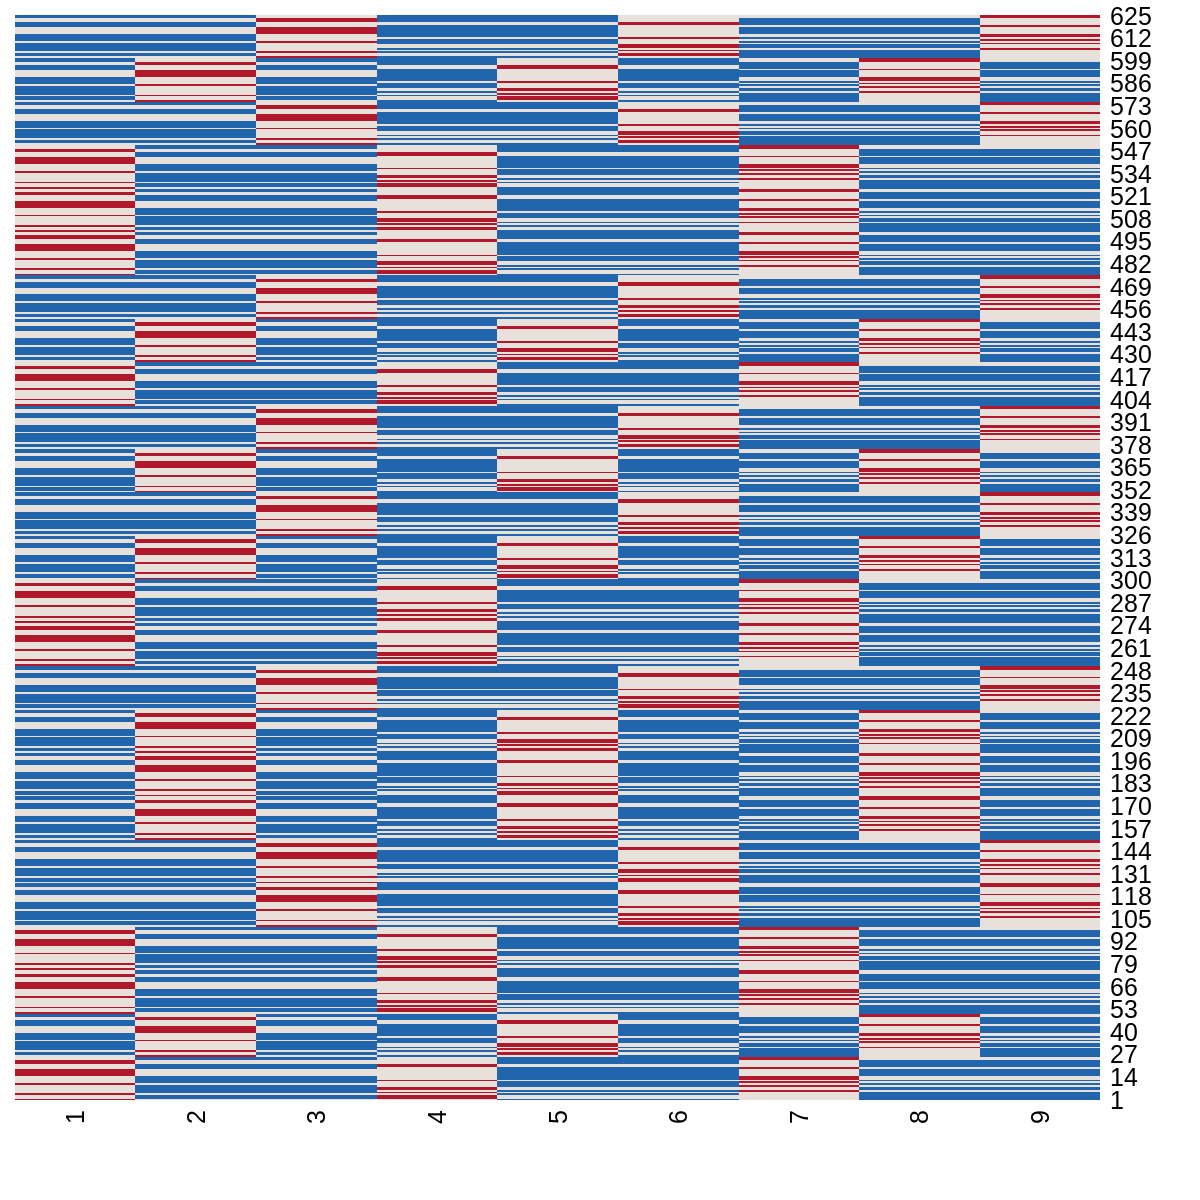

In [ ]:
# The function plt_smpls is defined at the end of the Notebook
plt_smpls(dml_pliv_obj$smpls[[1]], dml_pliv_obj$n_folds)

If we visualize the sample splitting in terms of the cluster variables, the partitioning of the data into $9$ folds $I_k \times J_\ell$ becomes clear.
The identifiers for the first cluster variable $[N]:=\{1,\ldots,N\}$ have been randomly partioned into $K=3$ folds denoted by $\{I_1, I_2, I_3\}$ and the identifiers for the second cluster variable $[M]:=\{1,\ldots,M\}$ have also been randomly partioned into $K=3$ folds denoted by $\{J_1, J_2, J_3\}$.
By considering every combination $I_k \times J_\ell$ for $1 \leq k, \ell \leq K = 3$ we effectively base the cross-fitting on $9$ folds.

We now want to focus on the top-left sub-plot showing the partitioning of the cluster data for the first fold.
The $x$-axis corresponds to the first cluster variable and the $y$-axis to the second cluster variable.
Observations with cluster variables $(i,j) \in I_K \times J_\ell$ are used for estimation of the target parameter $\tilde{\theta}_0$ by solving a Neyman orthogonal score function.
For estimation of the nuisance function, we only use observation where neither the first cluster variable is in $I_K$ nor the second cluster variable is in $J_\ell$, i.e., we use observations indexed by $(i,j)\in ([N]\setminus I_K) \times ([M]\setminus J_\ell)$ to estimate the nuisance functions
$$
\hat{\eta}_{k\ell} = \hat{\eta}\left((W_{ij})_{(i,j)\in ([N]\setminus I_K) \times ([M]\setminus J_\ell)}\right).
$$
This way we guarantee that there are never observations from the same cluster (first and/or second cluster dimension) in the sample for the nuisance function estimation (blue) and at the same time in the sample for solving the score function (red). As a result of this special sample splitting proposed by [Chiang et al. (2021)](https://doi.org/10.1080/07350015.2021.1895815), the observations in the score (red) and nuisance (blue) sample can be considered independent and the standard cross-fitting approach for double machine learning can be applied.

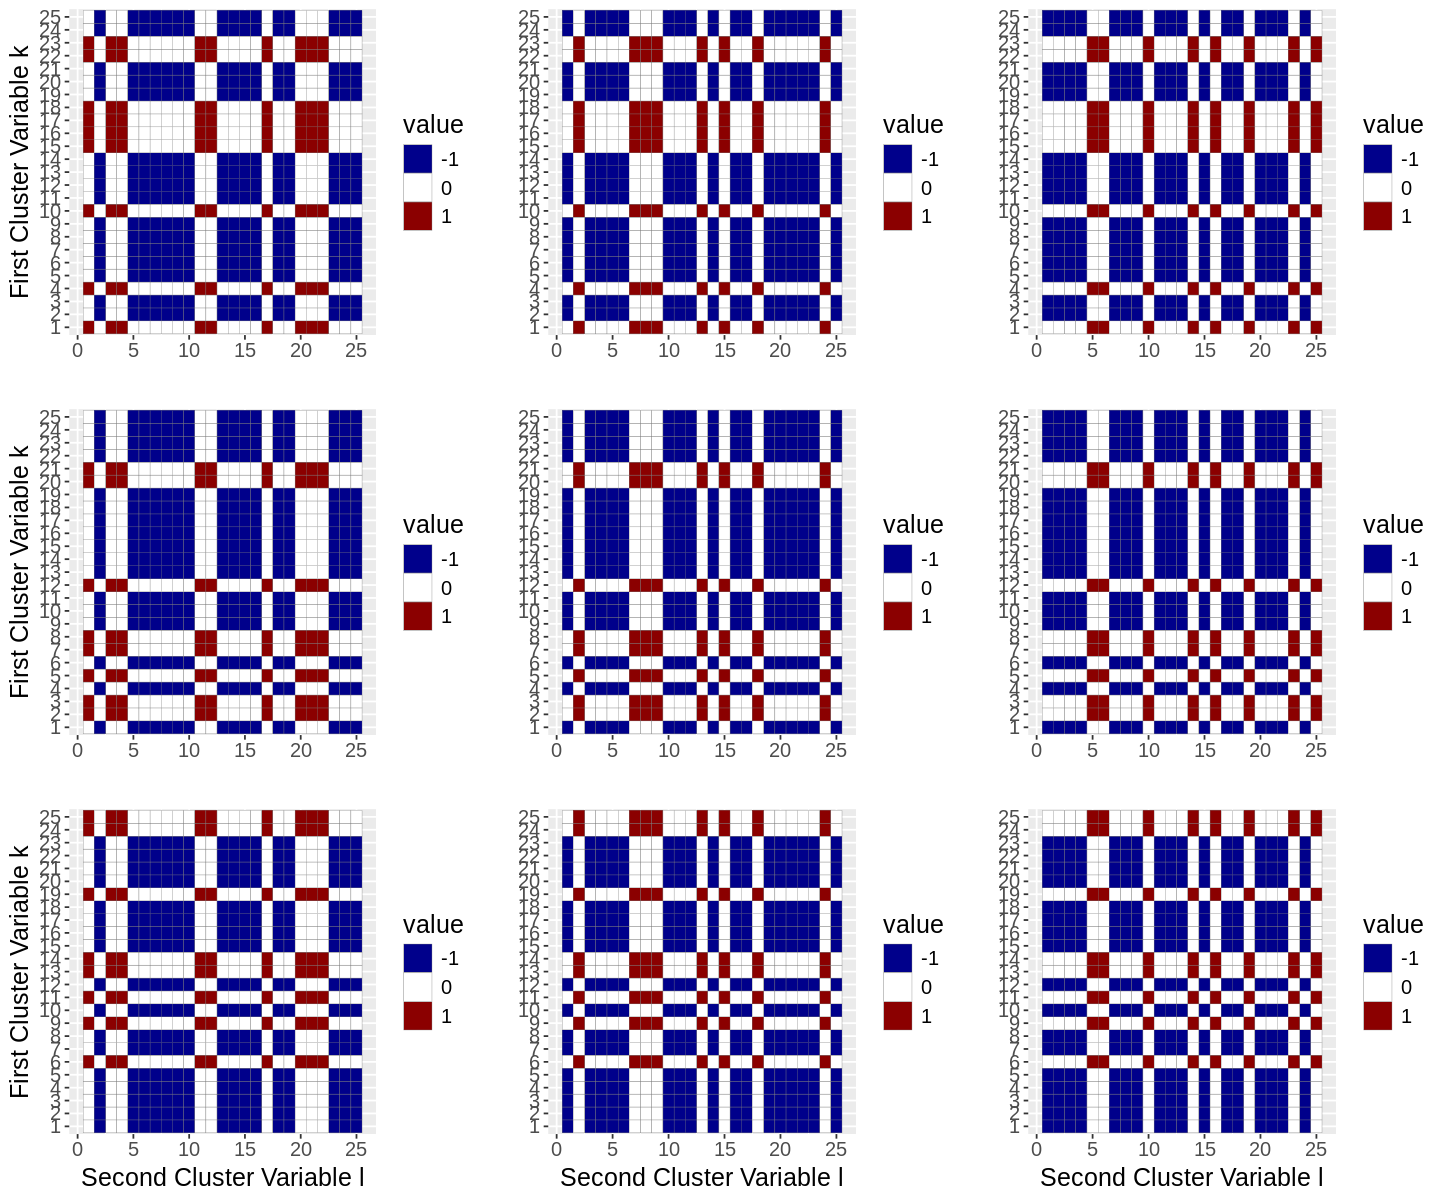

In [ ]:
# The function plt_smpls_cluster is defined at the end of the Notebook
options(repr.plot.width = 12, repr.plot.height = 10)
plots = plt_smpls_cluster(dml_pliv_obj$smpls_cluster[[1]],
                         dml_pliv_obj$n_folds,
                         sqrt(dml_pliv_obj$n_folds))
grid.arrange(grobs=plots, ncol = 3, nrow = 3)

### Cluster Robust Standard Errors
In the abstract base class `DoubleML` the estimation of cluster robust standard errors is implemented for all supported double machine learning models.
It is based on the assumption of a linear Neyman orthogonal score function.
We use the notation $n \wedge m := \min\{n,m\}$.
For the the asymptotic variance of
$\sqrt{\underline{C}}(\tilde{\theta_0} - \theta_0)$ with
$\underline{C} := N \wedge M$
[Chiang et al. (2021)](https://doi.org/10.1080/07350015.2021.1895815) then propose the following estimator
$$
\hat{\sigma}^2 = \hat{J}^{-1} \hat{\Gamma} \hat{J}^{-1}
$$
where
$$
\begin{aligned}
\hat{\Gamma} = \frac{1}{K^2} \sum_{(k, \ell) \in[K]^2}
\Bigg[ \frac{|I_k| \wedge |J_\ell|}{(|I_k||J_\ell|)^2}
\bigg(&\sum_{i \in I_k} \sum_{j \in J_\ell} \sum_{j' \in J_\ell}
\psi(W_{ij}; \tilde{\theta}, \hat{\eta}_{k \ell}) \psi(W_{ij'}; \tilde{\theta}_0, \hat{\eta}_{k \ell}) \\
&+ \sum_{i \in I_k} \sum_{i' \in I_k} \sum_{j \in J_\ell}
\psi(W_{ij}; \tilde{\theta}, \hat{\eta}_{k \ell}) \psi(W_{i'j}; \tilde{\theta}_0, \hat{\eta}_{k \ell})
\bigg)
\Bigg]
\end{aligned}$$
and
$$
\begin{aligned}
\hat{J} = \frac{1}{K^2} \sum_{(k, \ell) \in[K]^2} \frac{1}{|I_k||J_\ell|}
\sum_{i \in I_k} \sum_{j \in J_\ell}
\psi_a(W_{ij}; \tilde{\theta}_0, \hat{\eta}_{k \ell}).
\end{aligned}
$$
A $(1-\alpha)$ confidence interval is then given by ([Chiang et al. 2021](https://doi.org/10.1080/07350015.2021.1895815))
$$\begin{aligned}
\left[
\tilde{\theta} \pm \Phi^{-1}(1-\alpha/2) \sqrt{\hat{\sigma}^2 / \underline{C}}
\right]
\end{aligned}
$$
with $\underline{C} = N \wedge M$.

In [ ]:
# Estimate the PLIV model with cluster robust double machine learning
dml_pliv_obj$fit()
dml_pliv_obj$summary()

Estimates and significance testing of the effect of target variables
  Estimate. Std. Error t value Pr(>|t|)    
D    0.8909     0.1258   7.084  1.4e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




## (One-Way) Cluster Robust Double Machine Learing

We again use the PLIV data generating process described in Section 4.1 of [Chiang et al. (2021)](https://doi.org/10.1080/07350015.2021.1895815).
To obtain one-way clustered data, we set the following weights to zero
$$
\omega_2^X = \omega_2^\varepsilon = \omega_2^v = \omega_2^V = 0.
$$
Again we can simulate this data with [make_pliv_multiway_cluster_CKMS2021()](https://docs.doubleml.org/r/stable/reference/make_pliv_multiway_cluster_CKMS2021.html). To prepare the data-backend for one-way clustering, we only have to alter the `cluster_cols` to be `'cluster_var_i'`.

In [ ]:
obj_dml_data = make_pliv_multiway_cluster_CKMS2021(N, M, dim_X,
                                                   omega_X = c(0.25, 0),
                                                   omega_epsilon = c(0.25, 0),
                                                   omega_v = c(0.25, 0),
                                                   omega_V = c(0.25, 0))

In [ ]:
obj_dml_data$cluster_cols = 'cluster_var_i'
print(obj_dml_data)

================= DoubleMLClusterData Object ==================


------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): D
Cluster variable(s): cluster_var_i
Covariates: X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21, X22, X23, X24, X25, X26, X27, X28, X29, X30, X31, X32, X33, X34, X35, X36, X37, X38, X39, X40, X41, X42, X43, X44, X45, X46, X47, X48, X49, X50, X51, X52, X53, X54, X55, X56, X57, X58, X59, X60, X61, X62, X63, X64, X65, X66, X67, X68, X69, X70, X71, X72, X73, X74, X75, X76, X77, X78, X79, X80, X81, X82, X83, X84, X85, X86, X87, X88, X89, X90, X91, X92, X93, X94, X95, X96, X97, X98, X99, X100
Instrument(s): Z
No. Observations: 625


In [ ]:
# Set machine learning methods for l, m & r
ml_l = lrn("regr.cv_glmnet", nfolds = 10, s = "lambda.min")
ml_m = lrn("regr.cv_glmnet", nfolds = 10, s = "lambda.min")
ml_r = lrn("regr.cv_glmnet", nfolds = 10, s = "lambda.min")

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV$new(obj_dml_data,
                                ml_l, ml_m, ml_r,
                                n_folds=3)

In [ ]:
dml_pliv_obj$fit()
dml_pliv_obj$summary()

Estimates and significance testing of the effect of target variables
  Estimate. Std. Error t value Pr(>|t|)    
D   0.92905    0.04465   20.81   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




## Real-Data Application
As a real-data application we revist the consumer demand example from [Chiang et al. (2021)](https://doi.org/10.1080/07350015.2021.1895815).
The U.S. automobile data of [Berry, Levinsohn, and Pakes (1995)](https://doi.org/10.2307/2171802) is obtained from the `R` package [hdm](https://cran.r-project.org/web/packages/hdm/index.html). In this example, we consider different specifications for the cluster dimensions.

### Load and Process Data

In [ ]:
## Prepare the BLP data
data(BLP);
blp_data <- BLP$BLP;
blp_data$price <- blp_data$price + 11.761
blp_data$log_p = log(blp_data$price)

In [ ]:
x_cols = c('hpwt', 'air', 'mpd', 'space')
head(blp_data[x_cols])

,hpwt,air,mpd,space
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.5289969,0,1.888146,1.1502
2,0.4943244,0,1.935989,1.2780
3,0.4676134,0,1.716799,1.4592
4,0.4265403,0,1.687871,1.6068
5,0.4524887,0,1.504286,1.6458
6,0.4508706,0,1.726813,1.6224


In [ ]:
iv_vars = as.data.frame(hdm:::constructIV(blp_data$firm.id,
                            blp_data$cdid,
                            blp_data$id,
                            blp_data[x_cols]))

In [ ]:
formula = formula(paste0(" ~ -1 + (hpwt + air + mpd + space)^2",
                         "+ I(hpwt^2)*(air + mpd + space)",
                         "+ I(air^2)*(hpwt + mpd + space)",
                         "+ I(mpd^2)*(hpwt + air + space)",
                         "+ I(space^2)*(hpwt + air + mpd)",
                         "+ I(space^2) + I(hpwt^3) + I(air^3) + I(mpd^3) + I(space^3)"))
data_transf = data.frame(model.matrix(formula, blp_data))
names(data_transf)

[1] "hpwt"            "air"             "mpd"             "space"          
 [5] "I.hpwt.2."       "I.air.2."        "I.mpd.2."        "I.space.2."     
 [9] "I.hpwt.3."       "I.air.3."        "I.mpd.3."        "I.space.3."     
[13] "hpwt.air"        "hpwt.mpd"        "hpwt.space"      "air.mpd"        
[17] "air.space"       "mpd.space"       "air.I.hpwt.2."   "mpd.I.hpwt.2."  
[21] "space.I.hpwt.2." "hpwt.I.air.2."   "mpd.I.air.2."    "space.I.air.2." 
[25] "hpwt.I.mpd.2."   "air.I.mpd.2."    "space.I.mpd.2."  "hpwt.I.space.2."
[29] "air.I.space.2."  "mpd.I.space.2."

In [ ]:
y_col = 'y'
d_col = 'log_p'
cluster_cols = c('model.id', 'cdid')
all_z_cols = c('sum.other.hpwt', 'sum.other.mpd', 'sum.other.space')
z_col = all_z_cols[1]

In [ ]:
dml_df = cbind(blp_data[c(y_col, d_col, cluster_cols)],
               data_transf,
               iv_vars[all_z_cols])

### Initialize `DoubleMLClusterData` object

In [ ]:
dml_data = DoubleMLClusterData$new(dml_df,
                                   y_col=y_col,
                                   d_cols=d_col,
                                   z_cols=z_col,
                                   cluster_cols=cluster_cols,
                                   x_cols=names(data_transf))

In [ ]:
print(dml_data)

================= DoubleMLClusterData Object ==================


------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): log_p
Cluster variable(s): model.id, cdid
Covariates: hpwt, air, mpd, space, I.hpwt.2., I.air.2., I.mpd.2., I.space.2., I.hpwt.3., I.air.3., I.mpd.3., I.space.3., hpwt.air, hpwt.mpd, hpwt.space, air.mpd, air.space, mpd.space, air.I.hpwt.2., mpd.I.hpwt.2., space.I.hpwt.2., hpwt.I.air.2., mpd.I.air.2., space.I.air.2., hpwt.I.mpd.2., air.I.mpd.2., space.I.mpd.2., hpwt.I.space.2., air.I.space.2., mpd.I.space.2.
Instrument(s): sum.other.hpwt
No. Observations: 2217


In [ ]:
lasso = lrn("regr.cv_glmnet", nfolds = 10, s = "lambda.min")

In [ ]:
coef_df = data.frame(matrix(NA_real_, ncol = 4, nrow = 1))
colnames(coef_df) = c('zero-way', 'one-way-product', 'one-way-market', 'two-way')
rownames(coef_df) = all_z_cols[1]
se_df = coef_df
n_rep = 10

### Two-Way Clustering with Respect to Product and Market

In [ ]:
set.seed(1111)
dml_data$z_cols = z_col
dml_data$cluster_cols = c('model.id', 'cdid')
dml_pliv = DoubleMLPLIV$new(dml_data,
                            lasso, lasso, lasso,
                            n_folds=2, n_rep=n_rep)
dml_pliv$fit()
coef_df[1, 4] = dml_pliv$coef
se_df[1, 4] = dml_pliv$se

### One-Way Clustering with Respect to the Product

In [ ]:
set.seed(2222)
dml_data$z_cols = z_col
dml_data$cluster_cols = 'model.id'
dml_pliv = DoubleMLPLIV$new(dml_data,
                            lasso, lasso, lasso,
                            n_folds=4, n_rep=n_rep)
dml_pliv$fit()
coef_df[1, 2] = dml_pliv$coef
se_df[1, 2] = dml_pliv$se

### One-Way Clustering with Respect to the Market

In [ ]:
set.seed(3333)
dml_data$z_cols = z_col
dml_data$cluster_cols = 'cdid'
dml_pliv = DoubleMLPLIV$new(dml_data,
                            lasso, lasso, lasso,
                            n_folds=4, n_rep=n_rep)
dml_pliv$fit()
coef_df[1, 3] = dml_pliv$coef
se_df[1, 3] = dml_pliv$se

### No Clustering / Zero-Way Clustering

In [ ]:
dml_data = DoubleMLData$new(dml_df,
                            y_col=y_col,
                            d_cols=d_col,
                            z_cols=z_col,
                            x_cols=names(data_transf))

In [ ]:
print(dml_data)

================= DoubleMLData Object ==================


------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): log_p
Covariates: hpwt, air, mpd, space, I.hpwt.2., I.air.2., I.mpd.2., I.space.2., I.hpwt.3., I.air.3., I.mpd.3., I.space.3., hpwt.air, hpwt.mpd, hpwt.space, air.mpd, air.space, mpd.space, air.I.hpwt.2., mpd.I.hpwt.2., space.I.hpwt.2., hpwt.I.air.2., mpd.I.air.2., space.I.air.2., hpwt.I.mpd.2., air.I.mpd.2., space.I.mpd.2., hpwt.I.space.2., air.I.space.2., mpd.I.space.2.
Instrument(s): sum.other.hpwt
No. Observations: 2217


In [ ]:
set.seed(4444)
dml_data$z_cols = z_col
dml_pliv = DoubleMLPLIV$new(dml_data,
                            lasso, lasso, lasso,
                            n_folds=4, n_rep=n_rep)
dml_pliv$fit()
coef_df[1, 1] = dml_pliv$coef
se_df[1, 1] = dml_pliv$se

### Application Results

In [ ]:
coef_df

,zero-way,one-way-product,one-way-market,two-way
,<dbl>,<dbl>,<dbl>,<dbl>
sum.other.hpwt,-5.955409,-5.747945,-5.569911,-5.230198


In [ ]:
se_df

,zero-way,one-way-product,one-way-market,two-way
,<dbl>,<dbl>,<dbl>,<dbl>
sum.other.hpwt,0.5107762,0.9731447,0.715858,1.483749


## References
Berry, S., Levinsohn, J., and Pakes, A. (1995), Automobile Prices in Market
Equilibrium, Econometrica: Journal of the Econometric Society, 63, 841-890, doi: [10.2307/2171802](https://doi.org/10.2307/2171802).

Cameron, A. C., Gelbach, J. B. and Miller, D. L. (2011), Robust Inference with Multiway Clustering, Journal of Business & Economic Statistics, 29:2, 238-249, doi: [10.1198/jbes.2010.07136](https://doi.org/10.1198/jbes.2010.07136).

Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., Newey, W. and Robins, J. (2018), Double/debiased machine learning for treatment and structural parameters. The Econometrics Journal, 21: C1-C68, doi: [10.1111/ectj.12097](https://doi.org/10.1111/ectj.12097).

Chiang, H. D., Kato K., Ma, Y. and Sasaki, Y. (2021), Multiway Cluster Robust Double/Debiased Machine Learning, Journal of Business & Economic Statistics, doi: [10.1080/07350015.2021.1895815](https://doi.org/10.1080/07350015.2021.1895815), arXiv: [1909.03489](https://arxiv.org/abs/1909.03489).

## Define Helper Functions for Plotting

In [ ]:
library(RColorBrewer)
coul <- rev(colorRampPalette(brewer.pal(8, "RdBu"))(3))
options(repr.plot.width = 10, repr.plot.height = 10)

plt_smpls = function(smpls, n_folds) {
    df = matrix(0, nrow = N*M, ncol = n_folds)
    for (i_fold in 1:n_folds){
        df[smpls$train_ids[[i_fold]], i_fold] = -1
        df[smpls$test_ids[[i_fold]], i_fold] = 1
    }

    heatmap(df, Rowv=NA, Colv=NA, col=coul, cexRow=1.5, cexCol=1.5, scale='none')
}

plt_smpls_cluster = function(smpls_cluster, n_folds, n_folds_per_cluster) {
    #options(repr.plot.width = 6, repr.plot.height = 6)
    plots = list()
    for (i_fold in 1:n_folds){
        mat = matrix(0, nrow = M, ncol = N)
        for (k in smpls_cluster$train_ids[[i_fold]][[1]]) {
            for (l in smpls_cluster$train_ids[[i_fold]][[2]]) {
                mat[k, l] = -1
            }
        }
        for (k in smpls_cluster$test_ids[[i_fold]][[1]]) {
            for (l in smpls_cluster$test_ids[[i_fold]][[2]]) {
                mat[k, l] = 1
            }
        }
        l = (i_fold-1) %% n_folds_per_cluster + 1
        k = ((i_fold-1) %/% n_folds_per_cluster)+1
        df = data.frame(mat)
        cols = names(df)
        names(df) = 1:N
        df$id = 1:N
        df_plot = melt(df,  id.var = 'id')
        df_plot$value = factor(df_plot$value)
        plots[[i_fold]] = ggplot(data = df_plot, aes(x=id, y=variable)) +
          geom_tile(aes(fill=value), colour = "grey50") +
        scale_fill_manual(values = c("darkblue", "white", "darkred")) +
        theme(text = element_text(size=15))
        # ToDo: Add Subplot titles
        if (k == 3) {
            plots[[i_fold]] = plots[[i_fold]] + xlab(expression(paste('Second Cluster Variable ', l)))
        } else {
            plots[[i_fold]] = plots[[i_fold]] + xlab('')
        }
        if (l == 1) {
            plots[[i_fold]] = plots[[i_fold]] + ylab(expression(paste('First Cluster Variable ', k)))
        } else {
            plots[[i_fold]] = plots[[i_fold]] + ylab('')
        }
    }
    return(plots)
}